In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import date2num


%matplotlib inline

In [51]:
# subset the data to remove any negative values

def subset_state(state):
    # retrieves data from api, subsets by specified state
    state = state.upper()
    print("Running process for {}".format(state))
    stat = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
    if state != 'USA':
        stat = stat[stat['state']==state].copy()
    else:
        stat = stat.groupby('date').sum()
        stat.reset_index(inplace=True)
    stat['date'] = stat['date'].map(lambda x: datetime.strptime(str(x), '%Y%m%d'))
    stat['date_plt'] = date2num(stat['date'].tolist())
    max_date = str(stat['date'].max()).split(" ")[0]
    data_types = stat.dtypes
    for col in ['positive', 'death', 'positiveIncrease', 'totalTestResultsIncrease', 'deathIncrease']:
        stat = stat.loc[(stat[col] >= 0) | (stat[col].isnull())]
    print("Latest data from: {}".format(max_date))
#     print(stat.head())
    return stat

In [173]:
def get_today_stats(stat):
#     state = state.upper()
    
#     stat = subset_state(state)
    
    today = stat.sort_values('date').iloc[-1]
    date = today['date']
    total_tests = today['totalTestsViral']
    new_tests = today['totalTestResultsIncrease']
    new_cases = today['positiveIncrease']
    ratio = new_tests/new_cases
    hospitalized_now = today['hospitalizedCurrently']
    print(total_tests)
    
    # export data as json?
    print(today)

In [174]:
get_today_stats(subset_state('il'))

Running process for IL
Latest data from: 2020-06-19
1311003.0
date                                             2020-06-19 00:00:00
state                                                             IL
positive                                                      136470
negative                                                 1.17553e+06
pending                                                          NaN
hospitalizedCurrently                                           1837
hospitalizedCumulative                                           NaN
inIcuCurrently                                                   512
inIcuCumulative                                                  NaN
onVentilatorCurrently                                            293
onVentilatorCumulative                                           NaN
recovered                                                        NaN
dataQualityGrade                                                   A
lastUpdateEt                             

In [151]:
def plot_state_data(state, roll=7):
    # 
    state = state.upper()


    stat = subset_state(state)
    max_date = str(stat['date'].max()).split(" ")[0]
    
    # cumulative cases
    plt.plot(stat['date'], stat['positive'])
    plt.gcf().autofmt_xdate()
    plt.title("Cumulative Cases for {}".format(state))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("Total Cases")
#     plt.savefig(fname='cumulative_cases.png', format='png')
    plt.show()
    
    # cumulative deaths
    plt.plot(stat['date'], stat['death'])
    plt.gcf().autofmt_xdate()
    plt.title("Cumulative Deaths for {}".format(state))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("Total Deaths")
#     plt.savefig(fname='cumulative_deaths.png', format='png')
    plt.show()
    
    
    # ratio of new cases to new tests
    plt.plot(stat['date'], (stat['positiveIncrease']/ stat['totalTestResultsIncrease']).rolling(roll).mean(), c='g')
    plt.gcf().autofmt_xdate()
    plt.title("{state} Ratio of New Cases to New Tests ({roll}-day rolling mean)".format(state=state, roll=roll))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("New Case / New Tests")
    plt.show()
    
    # new cases
    plt.plot(stat['date'], stat['positiveIncrease'].rolling(roll).mean(), c='r')
    plt.plot(stat['date'], stat['positiveIncrease'], c='r', alpha=.25)
    plt.gcf().autofmt_xdate()
    plt.title("{state} New Cases ({roll}-day rolling mean)".format(state=state, roll=roll))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("New Case")
    plt.show()
    
    # new tests
    plt.plot(stat['date'], stat['totalTestResultsIncrease'].rolling(roll).mean(), c='b')
    plt.plot(stat['date'], stat['totalTestResultsIncrease'], c='b', alpha=.25)
    plt.gcf().autofmt_xdate()
    plt.title("{state} Tests per Day ({roll}-day rolling mean)".format(state=state, roll=roll))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("Tests per Day")
    plt.show()
    
    # new deaths
    plt.plot(stat['date'], stat['deathIncrease'].rolling(roll).mean(), c='y')
    plt.plot(stat['date'], stat['deathIncrease'], c='y', alpha=.25)
    plt.title("{state} Deaths per (Day {roll}-day rolling mean)".format(state=state, roll=roll))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("AVG Deaths per Day")
    plt.gcf().autofmt_xdate()
    plt.show()
    
    # new tests by new cases
    plt.plot(stat['date'], stat['positiveIncrease'].rolling(7).mean(), c='r')
    plt.plot(stat['date'], stat['totalTestResultsIncrease'].rolling(7).mean()/5, c='b')
    plt.legend(['new cases', 'new tests / 5'])
    plt.gcf().autofmt_xdate()
    plt.title("{state} New Cases and Tests ({roll}-day rolling mean)".format(state=state, roll=roll))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("New Cases or Tests")
    plt.show()
    
    
    # new cases to new deaths
    plt.plot(stat['date'], stat['deathIncrease'].rolling(7).mean(), c='y')
    plt.plot(stat['date'], stat['positiveIncrease'].rolling(7).mean()/10, c='r')
    plt.legend(['new deaths', 'new cases / 10'])
    plt.gcf().autofmt_xdate()
    plt.title("{state} New Cases and Deaths ({roll}-day rolling mean)".format(state=state, roll=roll))
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.ylabel("New Cases or Deaths")
    plt.show()
    
    # scatter plot new cases to new tests
    corr = stat[['positiveIncrease', 'totalTestResultsIncrease']].corr(method='spearman')['positiveIncrease'].tolist()[-1]
    plt.scatter(stat['totalTestResultsIncrease'],stat['positiveIncrease'])
    plt.title("New Confirmed Cases Compared to Tests Performed")
    plt.xlabel('{} New Tests Per Day'.format(state))
    plt.ylabel("New Confirmed Caeses Per Day\rThrough {}".format(max_date))
    plt.legend(['rho = {}'.format(str(corr)[:6])])
    plt.show()
    
    # active case breakdown
#     hos = stat[['date', 'inIcuCurrently', 'onVentilatorCurrently', 'positiveIncrease', 'hospitalizedCurrently', 'deathIncrease']].dropna()
    plt.plot(stat['date'], stat['inIcuCurrently'].rolling(roll).mean())
    plt.plot(stat['date'], stat['onVentilatorCurrently'].rolling(roll).mean())
    plt.plot(stat['date'], stat['hospitalizedCurrently'].rolling(roll).mean())
    plt.plot(stat['date'], stat['positiveIncrease'].rolling(roll).mean())
    plt.plot(stat['date'], stat['deathIncrease'].rolling(roll).mean())
    plt.gcf().autofmt_xdate()
    plt.legend(['In ICU', 'On Ventilator', 'In Hospital', 'New Cases', 'New Deaths'])
    plt.title("{} Active Case Breakdown".format(state))
    plt.ylabel('Patients in Category')
    plt.xlabel("Date\nThrough {}".format(max_date))
    plt.show()

    # cumulative tests?

Running process for NH
Latest data from: 2020-06-20


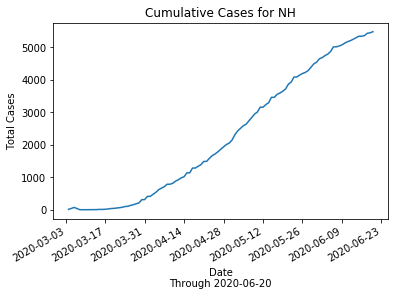

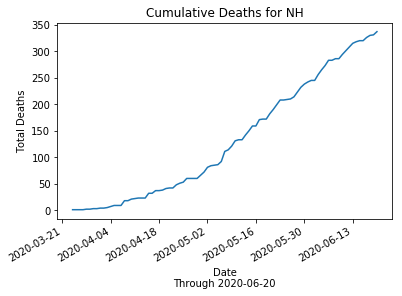

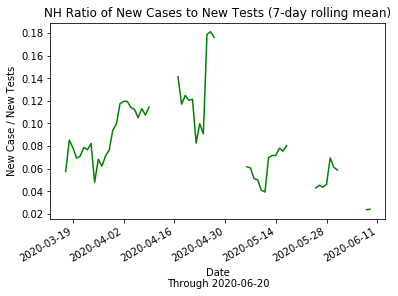

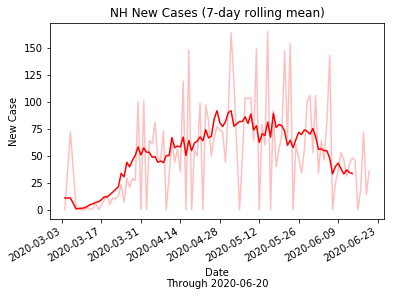

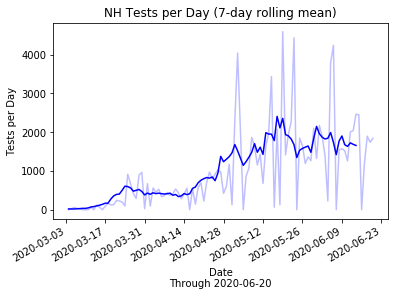

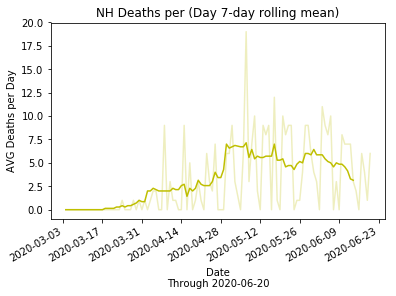

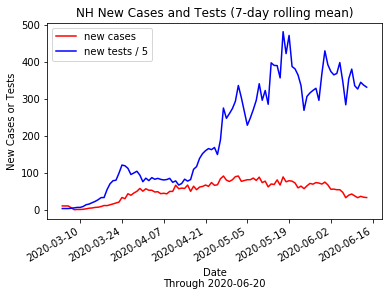

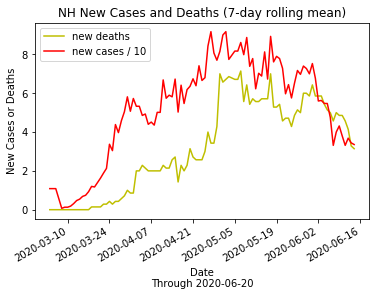

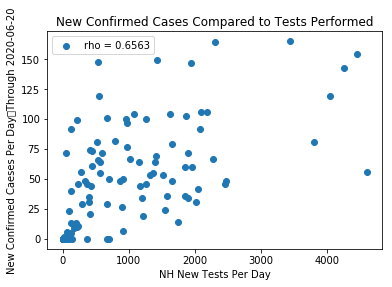

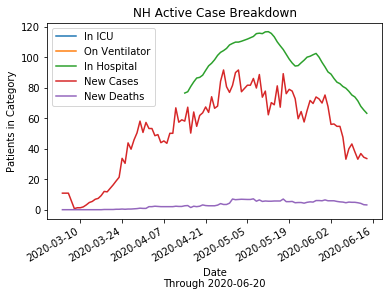

In [184]:
plot_state_data('nh')